In [20]:
#!"./setup-EForecast.sh"

%reload_ext autoreload
%autoreload 2

%matplotlib inline

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from doodahs import doodahs
from doodahs import APIfetch

In [2]:
# Import the different *.csv datasets and add the _state tag to all columns
weather_NSW, electricity_NSW = doodahs.import_n_statelabel('NSW')
weather_QLD, electricity_QLD = doodahs.import_n_statelabel('QLD')
weather_VIC, electricity_VIC = doodahs.import_n_statelabel('VIC')
weather_SA, electricity_SA = doodahs.import_n_statelabel('SA')

In [3]:
# join all electricity data
df_elec = electricity_NSW.join(electricity_QLD)
df_elec = df_elec.join(electricity_VIC)
df_elec = df_elec.join(electricity_SA)
df_elec = doodahs.create_diffs(df_elec, list(range(len(df_elec.columns))))

# outer join for all weather data
df_weather = weather_NSW.join(weather_QLD)
df_weather = df_weather.join(weather_VIC)
df_weather = df_weather.join(weather_SA)
df_weather = doodahs.create_diffs(df_weather, list(range(len(df_weather.columns))))

In [4]:
# re-sort dataset columns and extract test data y
df_elec = df_elec.reindex(sorted(df_elec.columns), axis=1)
y = df_elec.iloc[:,8:12]
for _ in y.columns:
    del df_elec[_]

print('elec shape: ',df_elec.shape)
print('y shape: ',y.shape)

# Create complete dataset of all train variables
df_all = df_weather.join(df_elec)

print('df_all shape: ',df_all.shape)

elec shape:  (445, 12)
y shape:  (445, 4)
df_all shape:  (445, 60)


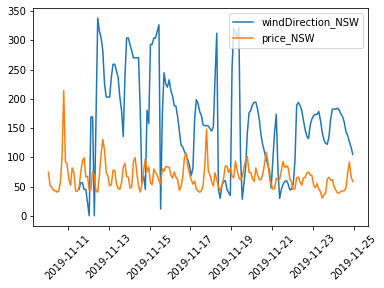

In [5]:
# Plotting of the different variables to look at possible trends in the data:
doodahs.plot_two_vars(weather_NSW, 3,electricity_NSW, 0, start='2019-11-10', end='2019-11-25', onediff=False, twodiff=False)
# No extremely obvious trends found, beyond the day/night periodicity

# After first exploration: 

    -$generated, $d_price, $d_temperature largest feature importance, with and small overlap to correlations ($generated, $d_price, $d_pressure) to $price

    -pairplot confirms corrs, most vars poisson distributed

    -simple linear combinations yield features w/ only slighly improved corr to $price

    -idea: cluster states & weather for extra features?
    -try more combinations between linear combos between different vars of/in different states

    -add features on holidays (look for that old function and time of day/ day of week feature

    -initial elementary feature engineering (-pear['testfeature'] = temp_df.temperature * temp_df.rain_prob * temp_df.wind_speed * temp_df.wind_direction) is in top5 features of 1k tree RF; higher .feature_importance_ are likely for better features

In [6]:
corr_NSW = (df_all.join(y.iloc[:,0])).corr()
corr_QLD = (df_all.join(y.iloc[:,1])).corr()
corr_SA = (df_all.join(y.iloc[:,2])).corr()
corr_VIC = (df_all.join(y.iloc[:,3])).corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# f, ax = plt.subplots(figsize=(11, 9))
# cmap = sns.diverging_palette(230, 0, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# sns.pairplot(corr_df)

In [7]:
# Four highest correlations to the electricity spot prices in NSW:
corr_NSW.price_NSW.sort_values(ascending=False)[1:5]

scheduledGeneration_QLD     0.701307
scheduledGeneration_NSW     0.673093
scheduledGeneration_SA      0.529868
d_scheduledGeneration_SA    0.461980
Name: price_NSW, dtype: float64

In [8]:
# ensure equal shape on both X & Y, so both train and test data share the same timeframe
df_all = df_all.dropna()
y = y[y.index.isin(df_all.index)]
# print(df_all.index.equals(y.index)) # test if indices are identical in X and Y data
#y = y[(y.index>=df_all.index[0]) & (y.index<=df_all.index[-1])]
#assert df_all.index == y.index, 'Index differs for df_all and y!'
y.shape

True


(214, 4)

In [9]:
# Fitting a multivariate linear model to the top i variables with the highest correlation to 'price_NSW':

for i in range(9,10):
    banana = list(corr_NSW.price_NSW.sort_values(ascending=False)[1:i].index)
    training_features = df_all[banana].iloc[0:187,:]

    test_features = y[['price_NSW']].iloc[0:187,:]

    predict_param = df_all[banana].iloc[188:199,:]

    lin1, lin1_pred = doodahs.linear_model_predictions(training_features, test_features, predict_param)

    #test_data = y[['price_NSW']].iloc[169:188,:]
    test_data = y[['price_QLD']].iloc[188:199,:]
    print(i,doodahs.model_MAE(lin1, lin1_pred, test_data,print_result=True))
    print(i,doodahs.rel_error(lin1, lin1_pred, test_data,print_result=True))

The model is inaccurate by $11.63 on average.
9 None
The model has a relative error of 20.9%.
9 None


Best accuracy reached for the 8 highest corr variables

In [10]:
# Fitting a Random Forest to the entire 60 variable dataset, testing for the influence of the train/test split:

for i in range(201,202):
    banana = list(corr_NSW.price_NSW.sort_values(ascending=False)[1:-1].index)
    
    training_features = df_all[banana].iloc[0:i,:]

    test_features = y[['price_NSW']].iloc[0:i,:]

    predict_param = df_all[banana].iloc[(i+1):213,:]

    RFR = RandomForestRegressor(n_estimators=1000, random_state=42)
    RFR.fit(training_features,np.ravel(test_features))
    RFR_pred = RFR.predict(predict_param)

    test_data = y[['price_VIC']].iloc[(i+1):213,:]
    print(i,doodahs.model_MAE(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))
    print(i,doodahs.rel_error(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))

The model is inaccurate by $14.34 on average.
201 None
The model has a relative error of 17.3%.
201 None


In [11]:
import pickle
filename = '5_models/RFR_best_2019-12-04_0-184train_185-187test-1ktrees.sav'
pickle.dump(RFR, open(filename, 'wb'))

In [12]:
# RFR.feature_importances_

# apple = pd.DataFrame()
# apple['feature'] = [*temp_df.iloc[:,1:16].columns]#,'testfeature']
# apple['importance'] = [*RFR.feature_importances_]
# apple.sort_values(by=['importance'], ascending=False)

# After second day am-sesh:

   -including data from all states extemely interesting. 
    E.g. scheduledGeneration_QLD has highest corr to price_NSW - different states!!!

    -excluding np.nan there are still ~200rows, 60 correlations

# EOD:

    -RF power increases dramatically the closer to the end of dataset we get 
    -RF efficacy hovers around ~10% rel acc, even predicting for other states
    after training on NSW price movements
    -linear model (9 highest corr to price_NSW) yields dramatically better
    results in the single digits rel err
    -RF shows that, e.g., the best features to predict prices in
    QLD are the scheduledGeneration_QLD, and scheduledGeneration_NSW,
    accounting for the im-/export of energy? (actually, it also comes
    down to these to to predict prices for SA)


In [13]:
# split dates into year month day day of week hour, etc for additional features 
df_all = doodahs.split_dates_df(df_all,)

# and this is what the new cols look like
# df_all.iloc[:,-7:-1].head(1)

In [14]:
# Fitting a Random Forest to the entire 60 variable dataset, testing for the influence of the train/test split:

for i in range(200,201):
    training_features = df_all.iloc[0:i,:]

    test_features = y[['price_NSW']].iloc[0:i,:]

    predict_param = df_all.iloc[(i+1):213,:]

    RFR = RandomForestRegressor(n_estimators=1000, random_state=42)
    RFR.fit(training_features,np.ravel(test_features))
    RFR_pred = RFR.predict(predict_param)

    test_data = y[['price_VIC']].iloc[(i+1):213,:]
    print(i,doodahs.model_MAE(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))
    print(i,doodahs.rel_error(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))

The model is inaccurate by $12.83 on average.
200 None
The model has a relative error of 15.1%.
200 None


# Some improvement, not great though.

Next step will be to hard code the time difference, shifting the price column by 1,2,3,...,n timesteps  

In [15]:
# data is binned in 2h timesteps thus the following shifts:
y_2h = doodahs.time_shift(y, 1)
y_2h.name = 1
y_6h = doodahs.time_shift(y, 3)
y_6h.name = 3
y_12h = doodahs.time_shift(y, 6)
y_12h.name = 6
y_24h = doodahs.time_shift(y, 12)
y_24h.name = 12
y_timeshift = [y_2h, y_6h, y_12h, y_24h]

In [16]:
# Fitting a Random Forest to the entire 60 variable dataset, testing for the influence of the train/test split:

for _a in y_timeshift:
    training_features = df_all.iloc[0:180,:]

    test_features = _a[['price_NSW']].iloc[0:180,:]

    predict_param = df_all.iloc[(181):188,:]

    RFR = RandomForestRegressor(n_estimators=1000, random_state=42)
    RFR.fit(training_features,np.ravel(test_features))
    RFR_pred = RFR.predict(predict_param)

    #shift = _a.name
    test_data = _a[['price_SA']].iloc[(181):188,:]
    print(_a.name,' timesteps shift', doodahs.model_MAE(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))
    print(_a.name,' timesteps shift', doodahs.rel_error(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))

The model is inaccurate by $8.76 on average.
1  timesteps shift None
The model has a relative error of 13.3%.
1  timesteps shift None
The model is inaccurate by $27.45 on average.
3  timesteps shift None
The model has a relative error of 1.46e+02%.
3  timesteps shift None
The model is inaccurate by $63.91 on average.
6  timesteps shift None
The model has a relative error of 1.17e+03%.
6  timesteps shift None
The model is inaccurate by $12.13 on average.
12  timesteps shift None
The model has a relative error of 20.1%.
12  timesteps shift None


Absolutely Rubbish, the accuracy yielded is atrocious.

keras.preprocessing.sequence.TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)


In [17]:
df_NSW = df_all[['temperature_NSW','rainProb_NSW', 'windSpeed_NSW', 'windDirection_NSW','cloudCover_NSW', 'pressure_NSW','d_temperature_NSW', 'd_rainProb_NSW', 'd_windSpeed_NSW','d_windDirection_NSW','d_cloudCover_NSW', 'd_pressure_NSW','d_price_NSW','d_scheduledGeneration_NSW','scheduledGeneration_NSW','year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_QLD = df_all[['temperature_QLD', 'rainProb_QLD', 'windSpeed_QLD', 'windDirection_QLD','cloudCover_QLD', 'pressure_QLD','d_temperature_QLD', 'd_rainProb_QLD', 'd_windSpeed_QLD','d_windDirection_QLD','d_cloudCover_QLD', 'd_pressure_QLD','d_price_QLD','d_scheduledGeneration_QLD','scheduledGeneration_QLD','year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_VIC = df_all[['temperature_VIC', 'rainProb_VIC', 'windSpeed_VIC', 'windDirection_VIC','cloudCover_VIC', 'pressure_VIC','d_temperature_VIC', 'd_rainProb_VIC', 'd_windSpeed_VIC','d_windDirection_VIC','d_cloudCover_VIC', 'd_pressure_VIC','d_price_VIC','d_scheduledGeneration_VIC','scheduledGeneration_VIC','year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_SA = df_all[['temperature_SA', 'rainProb_SA', 'windSpeed_SA', 'windDirection_SA','cloudCover_SA', 'pressure_SA','d_temperature_SA', 'd_rainProb_SA', 'd_windSpeed_SA','d_windDirection_SA','d_cloudCover_SA', 'd_pressure_SA','d_price_SA','d_scheduledGeneration_SA','scheduledGeneration_SA','year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

In [18]:
print(df_VIC.shape,df_QLD.shape,df_NSW.shape,df_SA.shape)

(214, 22) (214, 22) (214, 22) (214, 22)


In [19]:
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, LeakyReLU
from keras.layers import Reshape
from keras.models import Model
from keras.preprocessing.sequence import TimeseriesGenerator

# first linear NN model:
banana = list(corr_NSW.price_NSW.sort_values(ascending=False)[1:9].index)
training_features = df_all[banana].iloc[0:201,:]
test_features = y[['price_NSW']].iloc[0:201,:]
predict_param = df_all[banana].iloc[202:213,:]

input_size = training_features.shape[1]
inputs = Input(shape=(input_size,))

Dense1 = Dense(1, use_bias=True, kernel_initializer='normal', activation='linear')(inputs)

model_lin_nn = Model(inputs= inputs, outputs = Dense1)
model_lin_nn.compile(loss='mse', optimizer='adam')

history = model_lin_nn.fit(training_features, test_features, epochs=10)

doodahs.model_MAE(model_lin_nn, model_lin_nn.predict(predict_param),y[['price_NSW']].iloc[202:213,:], print_result=True)
doodahs.rel_error(model_lin_nn, model_lin_nn.predict(predict_param),y[['price_NSW']].iloc[202:213,:], print_result=True)

# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])








Epoch 1/10





201/201 [==============================] - 0s 2ms/step - loss: 60189.0634
Epoch 2/10
201/201 [==============================] - 0s 48us/step - loss: 25066.7217
Epoch 3/10
201/201 [==============================] - 0s 46us/step - loss: 6387.5555
Epoch 4/10
201/201 [==============================] - 0s 49us/step - loss: 889.7549
Epoch 5/10
201/201 [==============================] - 0s 47us/step - loss: 944.6381
Epoch 6/10
201/201 [==============================] - 0s 42us/step - loss: 1425.7644
Epoch 7/10
201/201 [==============================] - 0s 36us/step - loss: 980.5155
Epoch 8/10
201/201 [==============================] - 0s 34us/step - loss: 473.9131
Epoch 9/10
201/201 [==============================] - 0s 31us/step - loss: 339.5057
Epoch 10/10
201/201 [==============================] - 0s 29us/step - loss: 367.8723
The model is inaccurate by $14.55 on average.
The model has a relative error of 21.8%.


# Random Thoughts

keras.preprocessing.sequence.TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)

length=12? implies one day, neglects these interactions?

In [20]:
model_CNN = doodahs.func_CNN_1(df_QLD, nn_name='model_CNN')
model_CNN.compile(loss='mse', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
#model_CNN.summary()

In [22]:
import time
batch_size = 18
epochs = 100
start_time = time.time()
NSW = doodahs.reshape_for_CNN(df_NSW)
QLD = doodahs.reshape_for_CNN(df_QLD)
VIC = doodahs.reshape_for_CNN(df_VIC)
SA = doodahs.reshape_for_CNN(df_SA)

# This model optimises for the mse for all four states to be minimal:
model_CNN.fit([NSW[0:200,:], QLD[0:200,:], VIC[0:200,:], SA[0:200,:]], y.iloc[0:200,:],
          batch_size=batch_size,
          epochs=epochs,
          verbose=0)

print("--- {} seconds passed ---".format(time.time() - start_time))

# score = model_CNN.evaluate([NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]], y.iloc[201:213,:], verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

predictions = model_CNN.predict([NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]])

--- 12.425246238708496 seconds passed ---


In [23]:
mae, rel = doodahs.MAE_CNN(predictions, y.iloc[201:213,:])
print('---\nMAE in $ of \n{0}\n\nwith a relative error of\n{1}\n---'.format(mae, rel))

---
MAE in $ of 
price_NSW     8.799
price_QLD    11.211
price_SA     34.681
price_VIC    15.204
dtype: float64

with a relative error of
price_NSW     12.001
price_QLD     16.638
price_SA     228.911
price_VIC     18.657
dtype: float64
---


In [24]:
#reshap = Reshape((Layer.shape[1], 1), input_shape=(X.shape[1], ))(layer)
#model.fit_generator()

In [25]:
# the way it is set up, len(TimeseriesGenerator)= (len(data)-length)/batch_size, thus for #epochs>=6 and len(data)=190, length=16 and batch_size=29
# to calculate a good number of batches/epoch, use floor(#samples/batch_size), to avoid seeing datapoints multiple times during a single epoch

# DataGen_NSW = TimeseriesGenerator(df_all, y, 16, sampling_rate=1, stride=1, shuffle=False, reverse=False, batch_size=29)

In [26]:
model_CNN_2 = doodahs.func_CNN_2(df_all, nn_name='model_CNN_2')
losses = {'NSW_out': 'mse',
          'QLD_out': 'mse',
          'VIC_out': 'mse',
          'SA_out': 'mse'}
model_CNN_2.compile(loss=losses, optimizer='adam', metrics=['accuracy'])

In [27]:
#model_CNN_2.summary()

In [28]:
batch_sizes = 18
epochs = 100
start_time = time.time()
input_data = doodahs.reshape_for_CNN(df_all)

# data the model will be trained on (corresponding columns)
train_from = 0
train_to = 199
# data the current model (read: weights) are validated on
valid_from = 200
valid_to = 207
# data the final fit will be tested on, to make predictions for the last timesteps
test_from = 208
test_to = 213
y_2 = [y.iloc[:,0], y.iloc[:,1], y.iloc[:,2], y.iloc[:,3]]

history_2 = model_CNN_2.fit(input_data[train_from:train_to,:], 
                {'NSW_out': y.iloc[train_from:train_to,0],
                 'QLD_out': y.iloc[train_from:train_to,1],
                 'SA_out': y.iloc[train_from:train_to,2],
                 'VIC_out': y.iloc[train_from:train_to,3]},
                validation_data=(input_data[valid_from:valid_to,:],
                                 {'NSW_out': y.iloc[valid_from:valid_to,0],
                 'QLD_out': y.iloc[valid_from:valid_to,1],
                 'SA_out': y.iloc[valid_from:valid_to,2],
                 'VIC_out': y.iloc[valid_from:valid_to,3]}),
                batch_size=batch_sizes,
                epochs=epochs,
                verbose=1)

print("--- {} seconds passed ---".format(time.time() - start_time))

# score = model_CNN.evaluate([NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]], y.iloc[201:213,:], verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

predictions = model_CNN_2.predict(input_data[test_from:test_to,:])

000e+00 - QLD_out_acc: 0.0000e+00 - VIC_out_acc: 0.0000e+00 - SA_out_acc: 0.0000e+00 - val_loss: 1343.6166 - val_NSW_out_loss: 767.7978 - val_QLD_out_loss: 235.3053 - val_VIC_out_loss: 234.8408 - val_SA_out_loss: 105.6727 - val_NSW_out_acc: 0.0000e+00 - val_QLD_out_acc: 0.0000e+00 - val_VIC_out_acc: 0.0000e+00 - val_SA_out_acc: 0.0000e+00
Epoch 65/100
199/199 [==============================] - 0s 2ms/step - loss: 4646.9174 - NSW_out_loss: 130.4623 - QLD_out_loss: 216.3707 - VIC_out_loss: 233.1595 - SA_out_loss: 4066.9250 - NSW_out_acc: 0.0000e+00 - QLD_out_acc: 0.0000e+00 - VIC_out_acc: 0.0000e+00 - SA_out_acc: 0.0000e+00 - val_loss: 1379.9714 - val_NSW_out_loss: 712.5775 - val_QLD_out_loss: 294.8528 - val_VIC_out_loss: 278.5808 - val_SA_out_loss: 93.9603 - val_NSW_out_acc: 0.0000e+00 - val_QLD_out_acc: 0.0000e+00 - val_VIC_out_acc: 0.0000e+00 - val_SA_out_acc: 0.0000e+00
Epoch 66/100
199/199 [==============================] - 0s 2ms/step - loss: 4554.0301 - NSW_out_loss: 129.1397 - QL

In [29]:
# Date = '2019-12-04'
# model_CNN_2.save('CNN-2_best_{0}_{1}-{2}train_{3}-{4}test_{5}-{6}valid'.format(Date,train_from,train_to,test_from,test_to,valid_from,valid_to))

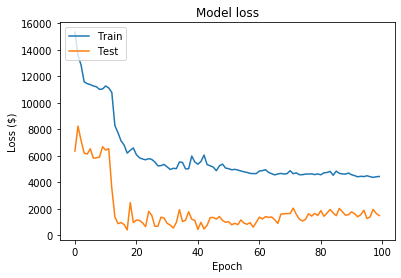

In [31]:
import matplotlib.pyplot as plt
n = 5
plt.plot([history_2.history['loss'][i] for i in range(len(history_2.history['loss'])) if i%1==0])
plt.plot([history_2.history['val_loss'][i] for i in range(len(history_2.history['val_loss'])) if i%1==0])
plt.title('Model loss')
plt.ylabel('Loss ($)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [118]:
mae2, rel2 = doodahs.MAE_CNN(model_CNN_2, input_data[test_from:test_to,:], 
                             y.iloc[test_from:test_to,:])
print('---\nMAE in $ of \n{0}\n\nwith a relative error of\n{1}\n---'.format(mae, rel))

ValueError: Must pass 2-d input

In [240]:
scores = model_CNN_2.evaluate(input_data[test_from:test_to,:],
                              {'NSW_out': y.iloc[test_from:test_to,0],
                 'QLD_out': y.iloc[test_from:test_to,1],
                 'SA_out': y.iloc[test_from:test_to,2],
                 'VIC_out': y.iloc[test_from:test_to,3]},
                              verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

5/5 [==============================] - 0s 1ms/step
Test loss: 6045.06640625
Test accuracy: 854.263671875


100 epochs
Test loss: 7413.81591796875
Test accuracy: 1278.9322509765625
300 epochs
Test loss: 7438.9453125
Test accuracy: 1236.485595703125
1k epochs:
Test loss: 6872.3994140625
Test accuracy: 1021.5670166015625
3k epochs:
Test loss: 6045.06640625
Test accuracy: 854.263671875

In [115]:
history_2.history['loss'][5]

3829.5863533978486

In [191]:
a = model_CNN_2.predict(input_data[test_from:test_to,:])
a

[array([[39.987057],
        [39.385937],
        [32.543476],
        [40.515297],
        [43.96108 ]], dtype=float32), array([[37.289913],
        [35.124844],
        [28.453451],
        [39.7536  ],
        [39.320198]], dtype=float32), array([[41.041668],
        [42.34884 ],
        [36.650158],
        [50.646946],
        [51.73896 ]], dtype=float32), array([[43.2014  ],
        [42.156723],
        [42.97286 ],
        [53.010185],
        [51.85682 ]], dtype=float32)]

In [195]:
b = pd.DataFrame(index=[0,1,2,3,4], columns=['NSW', 'QLD', 'SA', 'VIC'])

In [173]:
y.iloc[test_from:test_to,:].columns

[autoreload of modules.doodahs failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/jovyan/modules/doodahs.py", line 373
    temp_ = pd.DataFrame

Index(['price_NSW', 'price_QLD', 'price_SA', 'price_VIC'], dtype='object')

In [193]:
a= [a[_].reshape((1,5)) for _ in range(len(a))]

In [190]:
a

[array([[39.987057, 39.385937, 32.543476, 40.515297, 43.96108 ]],
       dtype=float32),
 array([[37.289913, 35.124844, 28.453451, 39.7536  , 39.320198]],
       dtype=float32),
 array([[41.041668, 42.34884 , 36.650158, 50.646946, 51.73896 ]],
       dtype=float32),
 array([[43.2014  , 42.156723, 42.97286 , 53.010185, 51.85682 ]],
       dtype=float32)]

In [197]:
c = pd.DataFrame(a[0])

[autoreload of modules.doodahs failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/jovyan/modules/doodahs.py", line 375
    for _ in
           

# pipeline from amphora into this .ipynb:

In [4]:
import amphora_client
from doodahs import APIfetch

In [5]:
banana = APIfetch.fetch_data(APIfetch.establish_connection(),'weather_QLD')

NameError: name 'amphora_api' is not defined

In [6]:
APIfetch.establish_connection()

NameError: name 'amphora_client' is not defined

In [2]:
# Amphora IDs used for model:
ids= {'electricity_NSW': 'ecc5263e-83b6-42d6-8852-64beffdf204e',
          'weather_QLD': 'a46f461f-f7ee-4cc5-a1e4-569960ea5ed8',
          'electricity_SA': '89c2e30d-78c8-46ef-b591-140edd84ddb6',
          'electricity_QLD': 'ef22fa0f-010c-4ab1-8a28-a8963f838ce9',
          'electricity_VIC': '3b66da5a-0723-4778-98fc-02d619c70664',
          'weather_NSW': '11fd3d6a-12e4-4767-9d52-03271b543c66',
          'weather_VIC': 'd48ac35f-c658-41c1-909a-f662d6f3a972',
          'weather_SA': '860ba45-9dda-41e0-91aa-73901a323318'}

ecc5263e-83b6-42d6-8852-64beffdf204e
a46f461f-f7ee-4cc5-a1e4-569960ea5ed8
89c2e30d-78c8-46ef-b591-140edd84ddb6
ef22fa0f-010c-4ab1-8a28-a8963f838ce9
3b66da5a-0723-4778-98fc-02d619c70664
11fd3d6a-12e4-4767-9d52-03271b543c66
d48ac35f-c658-41c1-909a-f662d6f3a972
860ba45-9dda-41e0-91aa-73901a323318
